# Introdução à Ciência de Dados

## Projeto Final - Rentabilidade de IPO's Brasileiros

### Integrantes:
Davi Ribeiro Pereira Pinto - 20200023844

Gabriel Araújo de Azevedo Lima - 20200026120

Thalles Emannuel Batista Pinheiro - 20200025580


# 1 Introdução

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Não há sombra de dúvidas que o mercado financeiro é um ambiente o 
qual promove inúmeras oportunidades para o crescimento do pequeno, médio e 
grande investidor, os quais se mostram extremamente atraídos pelas 
seduzentes chances de multiplicação de capital, especialmente por meio do 
investimento em negócios listados na bolsa de valores.<br />
&nbsp;&nbsp;&nbsp;&nbsp;Ao visualizar o crítico cenário socioeconômico no início e decorrer da 
pandemia do Covid-19, o número de investidores no país cresceu de maneira 
nunca vista antes. A possibilidade de ganhar dinheiro de maneira estratosférica 
– como é divulgado na mídia - com compra e venda de ações sem sair de casa 
pareceu uma ideia sensacional para a população.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Empresas de grande reputação como a IRB Brasil RE tiveram o valor de 
suas ações reduzido a uma fração do que já foi. A chance de multiplicação de 
capital pelo baixissimo preço dos papéis oferecido e a expectativa de 
recuperação num futuro próximo fez com que os investidores ficassem com 
medo de perder essa oportunidade única.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Um fator importante para o aumento de investidores em renda variável foi 
a diminuição da taxa básica de juros, a qual variou de 6,40% no início de 2019 
para 4,15% no início de 2020, descendo até atingir o patamar de 1,9% pelo fim 
do ano. Tal cenário tornou a renda variável um investimento mais atrativo e 
valoroso, uma vez que a renda fixa não se mostrava valer a pena. <br />
</div> 

Dados disponíveis em: [Banco Central do Brasil](https://www.bcb.gov.br/controleinflacao/historicotaxasjuros).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import numpy as np
from scipy.stats import linregress
from IPython.display import clear_output

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [3]:
investidores = pd.read_excel("./datasets/Investidores.xlsx")
investidores = investidores.melt(id_vars='Ano', value_vars=['Homens', 'Mulheres']).rename(columns={"variable": 'Genero', 
                                                                                                   "value": 'Quantidade'})
investidores['Quantidade'] /= 1000000 
investidores.head()

,Ano,Genero,Quantidade
0,2021,Homens,2.707331
1,2020,Homens,2.382966
2,2019,Homens,1.277424
3,2018,Homens,0.634269
4,2017,Homens,0.478258


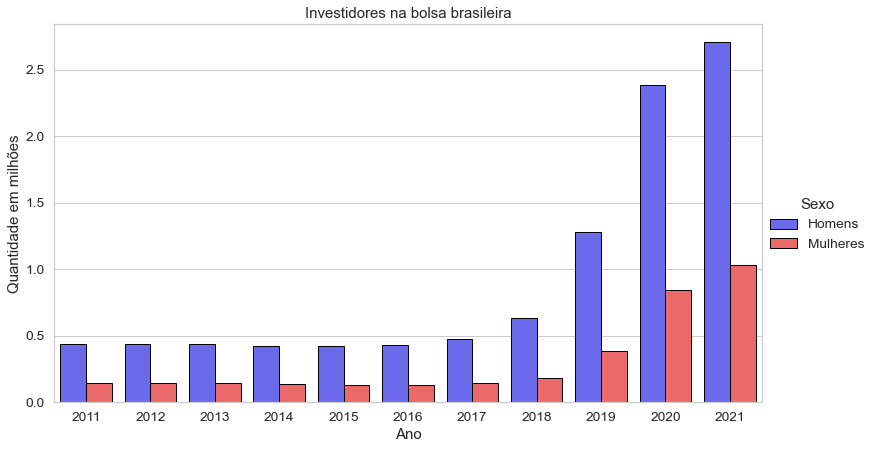

In [4]:
def plot_investidores(data):
    sns.set(font_scale = 1.25, style="whitegrid")
    g = sns.catplot(data=data, x="Ano", y="Quantidade", hue="Genero",
                    height=6, aspect=16/9, kind="bar", palette='seismic', ec = 'black')
    
    plt.title('Investidores na bolsa brasileira')
    g.despine(left=False, right=False, top=False)
    g.set_axis_labels("Ano", "Quantidade em milhões")
    g.legend.set_title("Sexo")
    plt.show()

plot_investidores(investidores)

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;É possível investir na bolsa de valores comprando e vendendo ações de 
empresas as quais foram listadas previamente, e a qualidade/potencial desse 
investimento é definido pelo histórico e fundamentos da companhia - apesar de 
ser possível gerar lucros com uma possível compra e venda do ativo baseado 
em análise gráfica ou de fluxo.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sob outra ótica, se uma pessoa decide investir em uma empresa durante 
os seus passos iniciais, seria um baita de uma compra visto que a empresa pode 
chegar em um valor muito maior ao que foi cotado inicialmente, afinal, essa 
pessoa comprou um ativo durante o seu nascimento!<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Essa é uma indagação que se fundamenta em uma pergunta feita 
recorrentemente no que tange ao investimento nesse mercado: Será que é 
possível gerar um bom retorno investindo em empresas que ainda estão para 
“lançar”?
</div>

## 1.1 Motivação
<br />
<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;IPO, ou Oferta pública inicial, é o processo pelo qual uma empresa passa 
para se tornar uma empresa de capital aberto, oferecendo a venda de suas 
ações ao público pela primeira vez. Popularmente no Brasil, o investimento 
nesse tipo de evento é geralmente malvisto. Isso ocorre pelo fato de não existir 
um histórico analisável da empresa, de modo a criar insegurança na hora de 
deixar o dinheiro nas mãos da companhia.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Entretanto, uma vez que existe a indagação previamente feita em algum 
lugar da mente do investidor – provido de experiência ou não - é extremamente 
válido recorrer à exploração e análise de dados para tentar responder essa 
pergunta e verificar, do ponto de vista de estudantes e investidores, se essa ideia 
vale a pena ser abraçada.
</div>


## 1.2 Objetivos
<br />
<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Nosso objetivo é verificar e calcular informações relevantes para o 
investidor, como a rentabilidade e a volatilidade dos papéis, a fim de compará-los a essas mesmas informações oriundas do Índice Bovespa, o qual representa um investimento em ações de empresas da velha guarda que fundamentam a 
economia do país. Dependendo dessa comparação, o investimento nessa classe 
de ativos - IPOs - se torna válida para execução.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Além disso, buscamos correlações entre a alta rentabilização de uma 
empresa em IPO e alguma outra variável, com o propósito de descobrir se 
alguma característica especifica do papel - à parte dos fundamentos - tem 
influência no sucesso da empresa durante a sua oferta pública. 
</div>

# 2 Dados utilizados
<br />
<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A priori, decidimos analisar uma amostra de dados dentro do período de 
2015 até 2021, no qual buscamos informações como a quantidade de IPOs, 
valorização dos ativos e alguns indicadores técnicos disponíveis durante a oferta 
pública inicial, dentre eles, o volume financeiro e a quantidade de 
estrangeiros/institucionais investindo no papel. Além disso, foi recolhido dados 
referentes à estatísticas do Covid-19 para fins comparativos.<br />

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Esses dados foram recolhidos a partir do site da [B3](http://www.b3.com.br/pt_br/) – Bolsa de Valores do Brasil, da biblioteca [Yahoo Finance](https://finance.yahoo.com/), do site da [Investing](https://br.investing.com/) e a partir do site do [Painel Coronavírus do Governo Federal](https://covid.saude.gov.br/).
</div>
    
Dados recolhidos:
* Cotação histórica das empresas que fizeram IPO entre 2015 e 2021 - ([B3](http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/));
* Cotação histórica do Índice Bovespa durante o mesmo período supracitado - ([Investing](https://br.investing.com/indices/bovespa-historical-data));
* Relatório das ofertas públicas realizadas (indicadores técnicos) - ([B3](http://www.b3.com.br/pt_br/produtos-e-servicos/solucoes-para-emissores/ofertas-publicas/estatisticas/));
* Dados referentes ao Covid-19.

Todos os dados utilizados estão unidos e disponíveis no [Github](https://github.com/davirpp/Projeto_Intro_CD/tree/master/datasets).

In [5]:
ipo_df = pd.read_csv("./datasets/COTAHIST_A2015_2021.csv")
ipo_details = pd.read_excel("./datasets/IPO_details.xlsx")
cota_ibov = pd.read_csv("./datasets/COTAHIST_IBOV.csv")
covid_df = pd.read_csv("./datasets/covid.csv")

# 3 Pré-processamento

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Os datasets buscados fornece informações sobre todos os ativos listados na bolsa, foi necessária uma filtragem a partir dos tickers específicos que queremos e uma estruturação adequada para a visualização dos dados.
</div>

## 3.1 Cotações Históricas

Nas células abaixos ocorre o pré-processamento dos dados conforme instruções contidas no layout adotado pela B3.
Que pode ser visto em: [Layout](http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf).

In [6]:
def create_csv_b3():
    year_i = int(input('Insira o ano de início: '))
    year_f = int(input('Insira o ano de término: '))
    years = list(range(year_i,year_f+1))

    list_ipos = ["PARC3", "WIZS3", "AALR3",
                 "MOVI3", "PARD3", "AZUL4", "CRFB3", "IRBR3", "OMGE3", "CAML3", "BKBR3", "BRDT3",
                 "GNDI3", "HAPV3", "BIDI4",
                 "SBFG3", "CNTO3","NEOE3", "VIVA3", "BMGB4", "CEAB3", 
                 "MTRE3", "LWSA3", "MDNE3", "PRNR3", "ALPK3", "AMBP3", "SOMA3", "DMVF3", "LJQQ3", "LAVV3", "PGMN3",
                 "PETZ3", "PLPL3", "MELK3", "HBSA3", "CURY3", "BOAS3", "SEQL3", "GMAT3", "TFCO4", "CASH3", "ENJU3", 
                 "AERI3", "RRRP3", "AVLL3", "RDOR3", "NGRD3", "HBRE3", "VAMO3", "ESPA3", "INTB3", "MOSI3", "MBLY3", 
                 "JALL3", "POWE3", "CSED3", "OPCT3", "ORVR3", "ELMD3", "BMOB3", "CMIN3", "WEST3", "MODL11", "MATD3", 
                 "BLAU3", "GGPS3", "SOJA3", "RECV3", "CXSE3", "ALLD3"]

    def b3_parser(year):
        cota = open(f"./datasets/datab3/COTAHIST_A{year}.txt",'r')
        head = cota.readline()
        line = cota.readline()
        all_data = []
        size = [2, 8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13, 13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3]
        col = ['tipreg', 'date', 'codbdi', 'codneg', 'tpmerc', 'nomres', 'especi', 'prazot', 'modref', 'preabe', 
               'premax', 'premin', 'premed', 'preult', 'preofc', 'preofv', 'totneg', 'quatot', 'voltot', 'preexe', 
               'indopc', 'datven', 'fatcot', 'ptoexe', 'codisi', 'dismes']
        #OBS.: The name of the columns is a pattern adopted by B3

        while line:
            dt = []
            x = 0
            for s in size: 
                dt.append(line[x:x+s]) 
                x+=s 
            all_data.append(dt)
            line = cota.readline()
            if line.startswith('99'): 
                break

        df = pd.DataFrame(data=all_data,columns=col)
        col = ['tipreg',  'codbdi',  'tpmerc', 'totneg', 'quatot', 'indopc', 'datven', 'fatcot',  'dismes']
        for c in col:
            df[c]=pd.to_numeric(df[c], downcast="integer")

        col = ['preabe', 'premax', 'premin', 'premed', 'preult', 'preofc', 'preofv','voltot', 'preexe','ptoexe']
        for c in col:
            df[c] = df[c].astype(float)/100

        col = ['date','datven']
        for c in col:
            df[c] = pd.to_datetime(df[c],format='%Y%m%d',errors='coerce')

        col = ['codneg']
        for c in col:
            df[c] = df[c].str.strip()

        return df

    def listFilter(dataframe, valores):
        return dataframe.loc[dataframe['codneg'].isin(valores)]

    df_list = []
    for year in years:
        df = b3_parser(year)
        df = listFilter(df, list_ipos)

        # CELL TO CHOOSE DESIRABLE COLUMNS
        df = df[['date','codneg','preabe','preult']]

        # RESETING INDEX
        df = df.reset_index(drop=True)

        # TRANSFORMING THE DATAFRAME IN CSV BY YEARS
        df.to_csv(f"COTAHIST_A{year}.csv", index = False)

        df_list.append(df)

    df = pd.read_csv(f"./COTAHIST_A{year_i}.csv")
    for year in range(year_i+1, year_f+1):
        df = pd.concat([df, pd.read_csv(f"./COTAHIST_A{year}.csv")])

    df.loc[df.codneg=='PARC3', 'codneg'] = 'WIZS3'
    df.loc[df.codneg=='CNTO3', 'codneg'] = 'SBFG3'

    # RESETING INDEX
    df = df.reset_index(drop=True)

    # TRANSFORMING THE DATAFRAME IN CSV OF ALL YEARS
    df.to_csv(f"COTAHIST_A{year_i}_{year_f}.csv", index = False)

In [7]:
#create_csv_b3()

## 3.2 Cotações Históricas Ajustadas Yahoo Finance

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O dataset do Yahoo Finance fornece informações sobre todos os ativos listados na bolsa, foi necessária uma filtragem a partir dos tickers específicos que queremos.
</div>

In [8]:
import pandas_datareader.data as web
#Caso não tiver a biblioteca Yahoo Finance, tire a '#' da linha abaixo.
#!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()
clear_output(wait=True)

In [9]:
tickers = list(ipo_details.Tickers)
openings = list(ipo_details.Preco_fixado)
dict_tickers = dict(zip(tickers, openings))

In [10]:
date_list = []
for ticker in tickers:
    df = ipo_df[ipo_df.codneg==ticker]
    df.sort_values(by='date')
    date_list.append(df["date"].iloc[0])
    
date_ipo_df = pd.DataFrame(list(zip(tickers, date_list)), columns=["tickers", "date"])
date_ipo_df["date"] = pd.to_datetime(date_ipo_df["date"], format='%Y-%m-%d')
date_ipo_df['year'] = date_ipo_df.apply(lambda x: x.date.year,axis=1)
date_ipo_df['month'] = date_ipo_df.apply(lambda x: x.date.month,axis=1)

In [11]:
date_ipo_dict = dict(zip(tickers, list(date_ipo_df['date']) ))
historico_dict = {}

for ticker in tickers:
    clear_output(wait=True)
    y_ticker = f'{ticker}.SA'
    historico = web.get_data_yahoo(y_ticker)
    historico = historico.reset_index(drop=False)[['Date','Adj Close']]
    historico.insert(1,'Ticker',0)
    historico['Ticker'] = historico.apply(lambda x: ticker,axis=1)
    historico = historico[historico.Date >= date_ipo_dict[ticker] ]
    historico_dict[ticker] = historico


hist = historico_dict['WIZS3']
for ticker in historico_dict:
    if ticker == 'WIZS3':
       continue
    hist = pd.concat([hist,historico_dict[ticker]])

hist = hist.sort_values('Date')
hist = hist.reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed


## 3.3 Cotação Índice Ibovespa 

In [12]:
def create_ibov():
    cota_ibov = pd.read_csv("./datasets/Cota_ibov.csv")
    def format_number(texto):    
        return float(texto.replace('.', '').replace(',', '.'))

    def format_percent(texto):   
        return float(texto.replace(',', '.').replace('%', ''))

    cota_ibov['Último'] = cota_ibov.apply(lambda x: format_number(x['Último']), axis=1)
    cota_ibov['Var%'] = cota_ibov.apply(lambda x: format_percent(x['Var%']), axis=1)

    ibov = cota_ibov[['Data', 'Último', 'Var%']].copy()

    ibov['Data'] = ibov.apply(lambda x: pd.to_datetime(x['Data'],format='%d.%m.%Y',errors='coerce'), axis=1)
    ibov = ibov.sort_values(by='Data', ascending = True)
    ibov = ibov.reset_index(drop=True)

    #Creating a column to calculate the acumulated rentability
    ibov['Cumulative'] = 0

    for i in range((ibov.index.max()) + 1):
        ibov.loc[i,'Cumulative'] = (((ibov.loc[i, 'Último'] / ibov.loc[0, 'Último']) - 1) * 100)

    # TRANSFORMING THE DATAFRAME IN CSV 
    ibov.to_csv(f"COTAHIST_IBOV.csv", index = False)

In [13]:
#create_ibov()

# 4 Perguntas

## 4.1 Quantos IPO's foram realizados de 2015 à Maio de 2021?

<br />
<div style="text-align: justify">
Para informar a reposta dessa pergunta, criamos um código o qual mostra os dados em um gráfico de barras.
</div>

In [14]:
#serie pandas dos anos:

ipos_per_year = date_ipo_df.groupby('year').count()
ipos_per_year = ipos_per_year.reset_index(drop=False)[['year','tickers']]
ipos_per_year = ipos_per_year.rename(columns={'year':'Ano', 'tickers':'Quantidade'})
ipos_per_year.Ano = ipos_per_year.apply(lambda x: str(x.Ano), axis = 1)

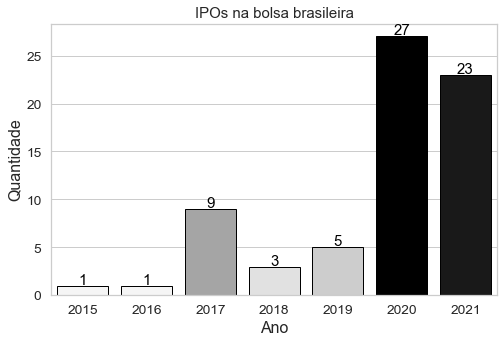

In [15]:
def plot_quantidade_ipos(data):
    ipos_per_year = data
    sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1.25, style='whitegrid')
    # sns.set(font_scale = 1.25)
    # sns.set_style('whitegrid')
    quant_year_b = sns.barplot(x='Ano', y='Quantidade', data=ipos_per_year, palette= cm.gist_yarg(ipos_per_year['Quantidade']*10),ec= 'black')
    quant_year_b.set_xlabel('Ano', fontsize = 16)
    quant_year_b.set_ylabel('Quantidade', fontsize = 16)
    for index, row in ipos_per_year.iterrows():
        quant_year_b.text(row.name, row.Quantidade+0.175, round(row.Quantidade,2), color="black", ha="center")
      
    plt.title('IPOs na bolsa brasileira')
    plt.show()

plot_quantidade_ipos(ipos_per_year)

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A primeira observação feita ao visualizar o gráfico é o enorme pico no ano 
de 2020, o que parece um pouco contraditório, visto que esse foi o ano de início 
da pandemia do coronavírus, e o lógico seria haver uma diminuição devido aos 
aparentes grandes riscos e crise econômica. Além disso, 2021 continua essa
tendência, tendo um valor maior do que a média.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Os anos anteriores não tiveram destaques expressivos, a não ser pelo 
ano de 2017, o qual registrou uma quantia não vista desde o registro de 10 IPOs
no ano de 2013. Esse período “inativo” de aberturas pode ter sido ocasionado 
por instabilidades políticas, impeachment e a alta taxa de juros durante o período.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O motivo pelo qual houve um crescimento expressivo em 2020 e 2021 se 
dá justamente pelo aumento da quantidade de investidores e diminuição da taxa 
de juros. Ao visualizar um mercado pouco concorrido e com ativos que “já 
andaram o que tinham que andar”, os investidores sentiram a necessidade de 
diversificar sua carteira com ações que fossem “recentes”, a fim de buscar a 
maior quantidade possível de oportunidades para rentabilizá-la. Logo, esse 
cenário se tornou extremamente favorável para a abertura de capital por parte 
das empresas que, de forma análoga aos investidores, usaram a oportunidade 
para alavancar suas empresas.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uma hipótese que também favorece esse crescimento é o aumento do 
fluxo de capital estrangeiro para dentro do Brasil. A taxa de juros no exterior se 
mostra muito mais afetada pela queda do que em nosso país, a qual torna quase 
nula ou negativa a rentabilidade de títulos de tesouro e renda fixa. Por conta 
disso, o investimento em países emergentes apresenta maior potencial de 
retorno, fazendo com que investidores estrangeiros migrem capital para países 
como o nosso e aqueçam ainda mais os setores da renda variável. 
</div>

## 4.2 Qual a rentabilidade dos IPOs considerando vendas dos ativos a curto, médio e longo prazo?

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A fim de responder essa pergunta, foi calculado o percentual de 
valorização de cada ativo em relação ao preço de fixação, ou seja, o preço pelo 
qual ele foi ofertado pela primeira vez.
</div>

Criamos 4 categorias para classificar a rentabilidade:
 * __Flipagem__ - Rentabilidade de um dia: compra pelo preço de fixação e venda na abertura do primeiro dia de negociação do ativo;
 * __Curto prazo__ - Rentabilidade de um mês: compra pelo preço de fixação e venda passados um mês da abertura;
 * __Médio prazo__ - Rentabilidade de três ou seis meses: compra pelo preço de fixação e venda passados de três ou seis meses da abertura;
 * __Longo prazo__ - Rentabilidade até hoje: venda não realizada até o 
momento.

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A rentabilidade em questão é de uma carteira que possui um ativo de cada 
empresa que fez IPO durante o período analisado. O objetivo da análise dos 
gráficos seria verificar qual categoria obteve os melhores resultados no que 
tange à rentabilização total da carteira.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O “hoje” referido na rentabilidade de longo prazo se refere à última data 
que nos oferece dados válidos, e o gráfico que mostra essa rentabilidade não foi 
representado, pois é uma rentabilidade que não se restringe a um periodo 
fechado de tempo. Abaixo estão os códigos e as visualizações dos dados obtidos.
</div>

In [16]:
def rentability(ticker, dias_uteis, dict_ticker=dict_tickers, data=ipo_df):
    ticker = ticker.upper()
    df = data[data.codneg==ticker]
    df = df.reset_index(drop=True)
    variation = ((df["preult"].iloc[dias_uteis-1]/dict_ticker[ticker])-1)*100
    return variation

In [17]:
ipos_dict = {}
for i in range(2015,2022):
    ipos_dict[i] = date_ipo_df[(date_ipo_df['date'] >= f'{i}-01-01') & (date_ipo_df['date'] <= f'{i}-12-31')]

In [18]:
rent_df_dict = {}
for year in range(2015,2022):
    columns=["1D", "1M", "3M", "6M"]
    rent_df_dict[year] = pd.DataFrame(columns=columns)
    time = [1, 20, 60, 120]
    tickers_temp = ipos_dict[year]["tickers"]
    for t in tickers_temp:
        lista = []
        for i in time:
            try:
                lista.append(rentability(t, i))
            except:
                lista.append(np.nan)
        rent_df_dict[year].loc[t] = lista
    rent_df_dict[year]['year'] = year

### 2015 a 2021

In [19]:
rent_df = pd.DataFrame(columns=["1D", "15D"])
time = [1, 10]
for t in tickers:
    rent_df.loc[t] = [rentability(t, c) for c in time]
rent_df.describe()

,1D,15D
count,69.000000,69.000000
mean,5.995371,5.621224
std,16.192957,17.366194
min,-27.586207,-27.764706
25%,-1.851852,-6.470588
50%,0.458333,4.216867
75%,8.947368,14.500000
max,96.969697,57.777778


In [20]:
def average_rentability_lineplot():
    total_average_dict = {}
    for c in ["1D", "1M", "3M", "6M"]:
        void_dict = {}
        for ano in range(2015, 2022):
            try:
                void_dict[ano] = [rent_df_dict[ano][c].mean(), rent_df_dict[ano][c].std()]
            except:
                void_dict[ano] = np.nan
        total_average_dict[c] = void_dict 
    return total_average_dict

In [21]:
average_lineplot = average_rentability_lineplot()

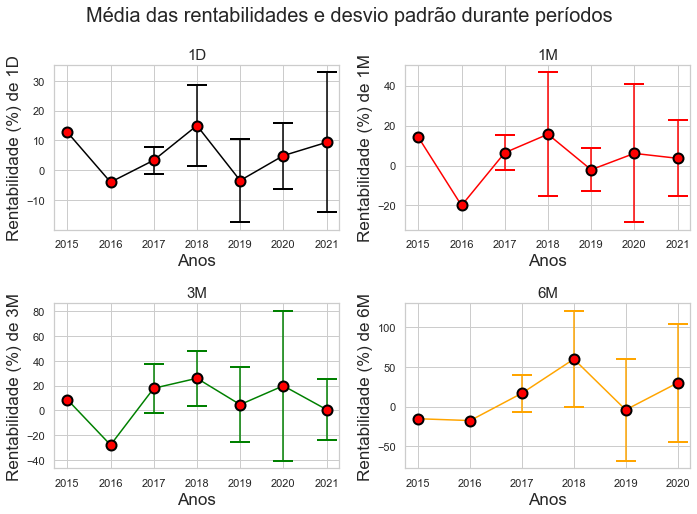

In [22]:
def plot_errobar(average_lineplot):
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set_style('whitegrid')

    colors = {'1D':'black','1M':'red','3M':'green','6M':'orange'}
    fig, axs = plt.subplots(2, 2)
    #fig.title('Title', pad=20)
    fig.suptitle('Média das rentabilidades e desvio padrão durante períodos\n\n', y=0.9, fontsize=20)

    for i,c in enumerate(['1D','1M','3M','6M']):
        df = pd.DataFrame(average_lineplot[c]).T
        x = np.array(df.index)
        y = np.array(df[0])
        erro = np.array(df[1])

        if i == 0 or i == 1:
            axs[0,i].errorbar(x,y,yerr=erro, 
                              color = colors[c], ls = '-', # cor e tipo da linha
                              fmt = 'o', mfc = 'red', mec = 'black',
                              mew = 2, ms = 10, 
                              ecolor = colors[c],
                              capsize = 10)

            axs[0,i].set_title(c, fontsize=15)
            axs[0,i].set_xlabel('Anos', fontsize = 17)
            axs[0,i].set_ylabel(f'Rentabilidade (%) de {c}', fontsize = 17)

        else:
            axs[1,i-2].errorbar(x,y,yerr=erro, 
                                color = colors[c], ls = '-', # cor e tipo da linha
                                fmt = 'o', mfc = 'red', mec = 'black',
                                mew = 2, ms = 10, 
                                ecolor = colors[c],
                                capsize = 10)

            axs[1,i-2].set_title(c, fontsize=15)

            axs[1,i-2].set_xlabel('Anos', fontsize = 17)
            axs[1,i-2].set_ylabel(f'Rentabilidade (%) de {c}', fontsize = 17)

        # plt.xlim([0,125])
        # plt.ylim([0,125])

    fig.tight_layout(pad=1.5)

plot_errobar(average_lineplot)

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Esse gráfico mostra, para cada categoria supracitada, a rentabilidade 
média e o desvio padrão para cada ano. O interessante a ser visualizado nesses 
exemplos, é a distância do desvio padrão em relação à média, que no caso, 
mostra até quão longe da média a rentabilidade de um ativo específico pode 
estar. O gráfico ilustra a distância igual a um desvio padrão, isso significa que 
68% dos valores de rentabilidade estão presentes dentro desse intervalo.
Quanto maior for essa distância, maior se torna o desequilíbrio e a distribuição
desigual da rentabilidade dos ativos listados.
</div>

 * __Exemplo__: uma média de 10% ao ano acompanhada de um desvio padrão 
de 20%, esse cenário indica que 68% dos valores que compõem essa 
média variam entre -10% até 30%

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Se o valor da rentabilidade de um ativo estiver negativa, ele está causando um 
rebaixamento na carteira, ou seja, diminuindo a rentabilidade média total e trazendo prejuízo.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Em maior parte do grafico, a média de rentabilidade é acompanhada de um expressivo desvio padrão, denotando o fato que a carteira possui uma distribuição muito dispersa da rentabilidade individual de cada ativo. Uma vez que o investimento hipotético é feito pela compra de todos os papéis, o tamanho 
do desvio padrão se torna um problema caso o limite inferior penetre
negativamente além do valor zero, indicando que há maiores chances de 
existirem ativos que deram prejuízo na carteira. Um alto desvio padrão também 
indica que existe a possibilidade de alcançar uma rentabilidade muito maior se a 
empresa que teve um prejuízo alto fosse descartada, e o caso recíproco é verdadeiro.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Nos gráficos de um dia, um mês e três meses, a média da rentabilidade 
ficou bem abaixo de zero apenas no ano de 2016, o qual teve o IPO de apenas
uma empresa. Esse ano gerou um alto rebaixamento na carteira em periodos de 
tempo maiores, pois infelizmente, a empresa listada nesse ano não obteve 
sucesso no período em questão, de modo a fechar com rentabilidade negativa. 
Entretanto, apesar desse fato, a rentabilidade média se mostrou positiva ou 
mínimamente negativa durante os outros anos, com exceção da rentabilidade 
semestral em 2015.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O gráfico de um mês é extremamente semelhante ao gráfico da flipagem,
mas com um desvio padrão geral e perda em 2016 muito maiores. Levando em 
consideração a proximidade dos gráficos, o fato de que não podemos remover
ativos perdedores da carteira e que um maior desvio padrão significa um possível 
maior rebaixamento, a flipagem se mostra um ato mais interessante do que a 
compra e venda com um mês de intervalo. Além disso, a rentabilidade média 
acumulada do período de flipagem se mostrou 14,17% maior do que a de um 
mês, comprovando sua maior eficiência.
    
</div>

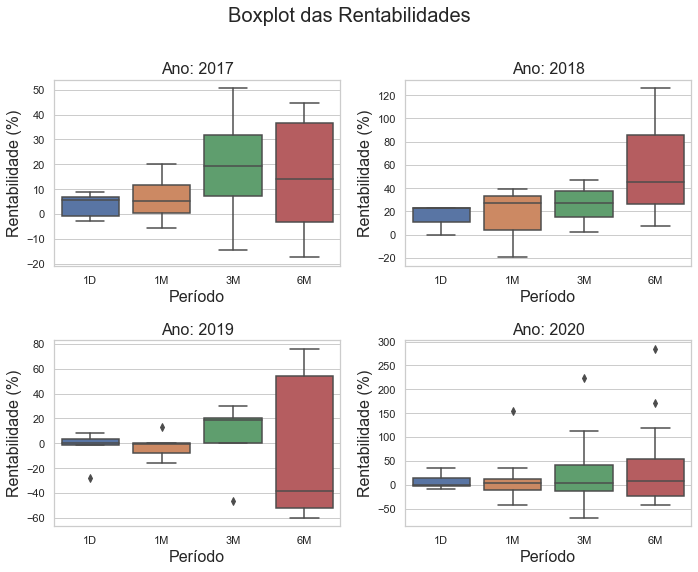

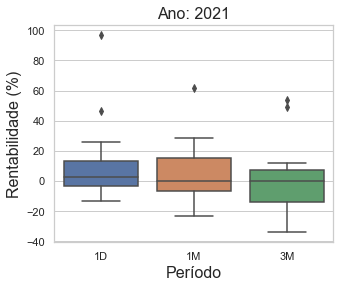

In [23]:
def plot_boxplots():
    sns.set(rc={'figure.figsize':(10,8)}, style='whitegrid')

    fig, axs = plt.subplots(2,2)
    #fig.title('Title', pad=20)
    fig.suptitle('Boxplot das Rentabilidades', y=1, fontsize=20)

    for year in range(2017,2022):
        x = rent_df_dict[year].copy()
        x['Ativo'] = list(x.index)
        x = x.reset_index(drop=True).melt(id_vars='Ativo', value_vars=['1D', '1M', '3M','6M'])

        if year in [2017,2018]:
            sns.boxplot(ax = axs[0,year-2017], data = x, x="variable", y='value')
            axs[0,year-2017].set_xlabel('Período', fontsize = 16)
            axs[0,year-2017].set_ylabel('Rentabilidade (%)', fontsize = 16)
            axs[0,year-2017].set_title(f'Ano: {year}', fontsize = 16)
        
        if year in [2019,2020]:
            sns.boxplot(ax = axs[1,year-2019], data = x, x="variable", y='value')
            axs[1,year-2019].set_xlabel('Período', fontsize = 16)
            axs[1,year-2019].set_ylabel('Rentabilidade (%)', fontsize = 16)
            axs[1,year-2019].set_title(f'Ano: {year}', fontsize = 16)

        # plt.xlim([0,125])
        # plt.ylim([0,125])  
    fig.tight_layout(pad=1.5)

def plot_boxplots2():
    sns.set(rc={'figure.figsize':(5,4)}, style='whitegrid')
    #fig.suptitle('Boxplot das Rentabilidades', y=1.02, fontsize=20)
    year = 2021
    x = rent_df_dict[year].copy()
    x['Ativo'] = list(x.index)
    x = x.reset_index(drop=True).melt(id_vars='Ativo', value_vars=['1D', '1M','3M'])
   
    g_2021 = sns.boxplot(data = x, x="variable", y='value')
    g_2021.set_xlabel('Período', fontsize = 16)
    g_2021.set_ylabel('Rentabilidade (%)', fontsize = 16)
    g_2021.set_title(f'Ano: {year}', fontsize = 16)

plot_boxplots()
plt.show()
plot_boxplots2()

In [24]:
def average_rentability_barplot():
    total_average_dict = {}
    for c in ["1D", "1M", "3M", "6M"]:
        void_dict = {}
        auxiliar = 0
        for ano in range(2015, 2022):
            try:
                x = rent_df_dict[ano][c].mean() + auxiliar
                void_dict[ano] = [rent_df_dict[ano][c].mean(), rent_df_dict[ano][c].std(), x]
                auxiliar = x
            except:
                void_dict[ano] = np.nan
        total_average_dict[c] = void_dict    
    return total_average_dict

In [25]:
average_barplot = average_rentability_barplot()

In [26]:
average_barplot_1d = pd.DataFrame(average_barplot["1D"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_1m = pd.DataFrame(average_barplot["1M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_3m = pd.DataFrame(average_barplot["3M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})
average_barplot_6m = pd.DataFrame(average_barplot["6M"]).T.reset_index().rename(columns = {"index": "Ano", 0: "Media", 1: "Desvio", 2: "Acumulada"})

In [27]:
average_barplot_6m = average_barplot_6m[0:6]

In [28]:
def plot_average_barplot(df, periodo):
    df = df.copy()
    df['m_plot'] = df.Media
    df.loc[0,'m_plot'] = np.nan
    df['m_pos'] = df.apply(lambda x: x.Media if x.Media > 0 else np.nan, axis = 1)
    df['m_neg'] = df.apply(lambda x: x.Media if x.Media < 0 else np.nan, axis = 1)    
    sns.set(rc={'figure.figsize':(8,5)}, font_scale = 1.15, style='whitegrid')
    list_media = list(df["Media"])
    list_acumulada = list(df["Acumulada"]) + list_media    
    plt.ylim([round(min(list_acumulada) - 5), round(max(list_acumulada) + 5)])
    axes = sns.lineplot(data = df["Acumulada"], marker='o', sort = False, color ='Red')
    axes2 = sns.barplot(data = df, x='Ano', y="Media", palette=cm.gist_yarg(df['Media']*10), alpha=0.9, ec= 'black')
    plt.suptitle(f"Rentabilidades com venda em {periodo}",y=0.98)
    plt.legend(labels=["Rentabilidade acumulada"], loc='upper left')
    plt.ylabel('Média (%)')
    
    maior = df.Acumulada.max()
    menor = df.Acumulada.min()
    if maior < df.Media.max():
        maior = df.Media.max()
    
    if menor > df.Media.min():
        menor = df.Media.min()

    plt.ylim([1.1*menor,1.2*maior])

    for index, row in df.iterrows():   
        #axes.text(row.name, row.Media, round(row.Media,2), color="black", ha="center")
        #axes.text(row.name, row.m_pos//2,/ round(row.m_pos,2), color="white", ha="center")
        #axes.text(row.name, row.m_neg//(3/2), round(row.m_neg,2), color="black", ha="center")
        axes2.text(row.name, row.Acumulada+2.1, round(row.Acumulada,2), color="black", bbox=dict(facecolor='white', alpha=0.5), ha="center")
    
    # clear_output(wait=True)

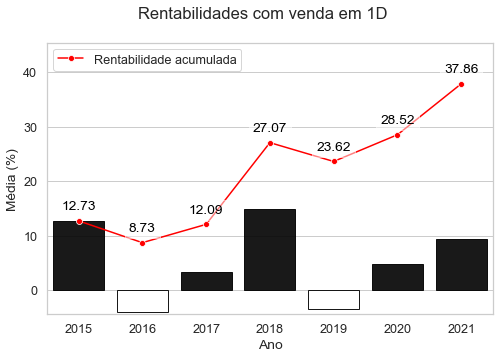

In [29]:
plot_average_barplot(average_barplot_1d,'1D')

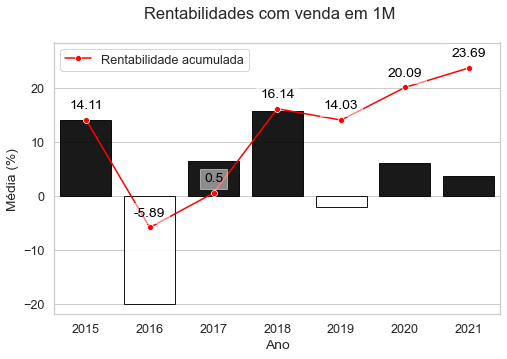

In [30]:
plot_average_barplot(average_barplot_1m,'1M')

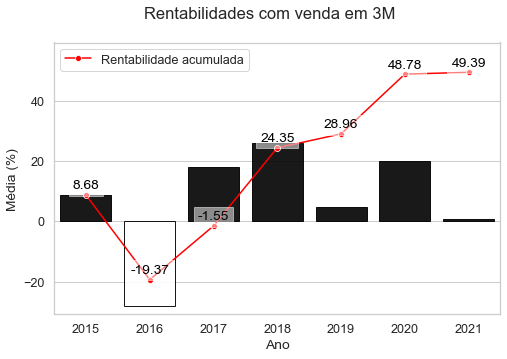

In [31]:
plot_average_barplot(average_barplot_3m,'3M')

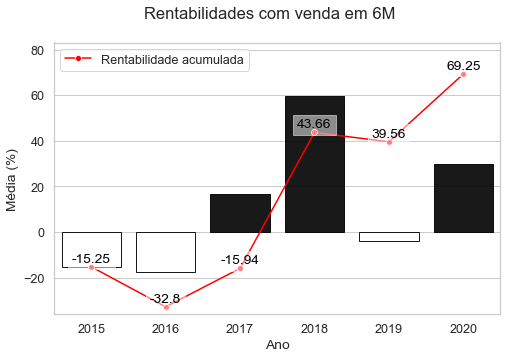

In [32]:
plot_average_barplot(average_barplot_6m,'6M')

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uma carteira que investiu em flipagens a partir de 2015 até 2021 teve uma 
rentabilidade final de 37,86%, e em nenhum momento ela se encontrou no 
prejuízo. Por outro lado, os investimentos de três e seis meses obtiveram uma 
rentabilidade maior, especialmente a de seis meses, 49,39% e 69,25% 
respectivamente, com o contraponto de terem rentabilizado negativamente em alguns anos.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A alta taxa de rentabilidade no ano de 2018 foi resultado do IPO do Banco 
Inter S.A., o qual obteve extremo sucesso e continua em crescimento até os dias 
de hoje. É por conta do crescimento de empresas como essa que os 
investimentos em IPO são cobiçados, pois a sua rentabilidade altíssima mostra 
quão poderosos essa classe de ativo pode ser.<br /> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Todos os gráficos mostram algo em comum: apesar das perdas e riscos 
de rebaixamento, a rentabilidade da carteira continua subindo. É muito difícil 
saber qual ativo vai valorizar ou não com os poucos dados disponíveis durante 
o IPO, mas em um cenário de investimentos realista - o qual é levado em conta gerenciamento de risco e dinheiro - ao passar do tempo é possível verificar quais 
empresas falharam em cumprir o seu propósito, possibilitando o descarte de 
ativos que podem continuar rebaixando a carteira.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Desse modo, investimentos de médio a longo prazo têm o diferencial de 
angariar informações durante um período maior, permitindo que o investidor faça 
o gerenciamento da sua carteira sempre que achar que o ativo não está dando 
bons retornos. Visto que a estatística mostra um resultado positivo e que o 
gerenciamento pode ajudar a reduzir rebaixamentos e alavancar resultados, é 
fato que o investimento em IPOs traz bons resultados para a carteira.<br />

</div>

## 4.3 Rentabilidade por setor

In [33]:
rent_by_day = hist.pivot_table(values='Adj Close', index='Date', columns='Ticker')

for c in rent_by_day: 
    fixing_close = hist[hist.Ticker == c].reset_index(drop=True).loc[0,'Adj Close']
    rent_by_day[c] = ((rent_by_day[c] / fixing_close) - 1)* 100

rent_by_day_mean = rent_by_day.mean(axis=1)
rent_by_day_mean = pd.DataFrame(data=rent_by_day_mean, columns=['variation'])
rent_by_day_mean = rent_by_day_mean.reset_index()
rent_by_day_mean['Date'] = rent_by_day_mean.apply(lambda x: pd.to_datetime(x.Date,format='%Y-%m-%d',errors='coerce'), axis=1)
rent_by_day_mean = rent_by_day_mean.set_index('Date')

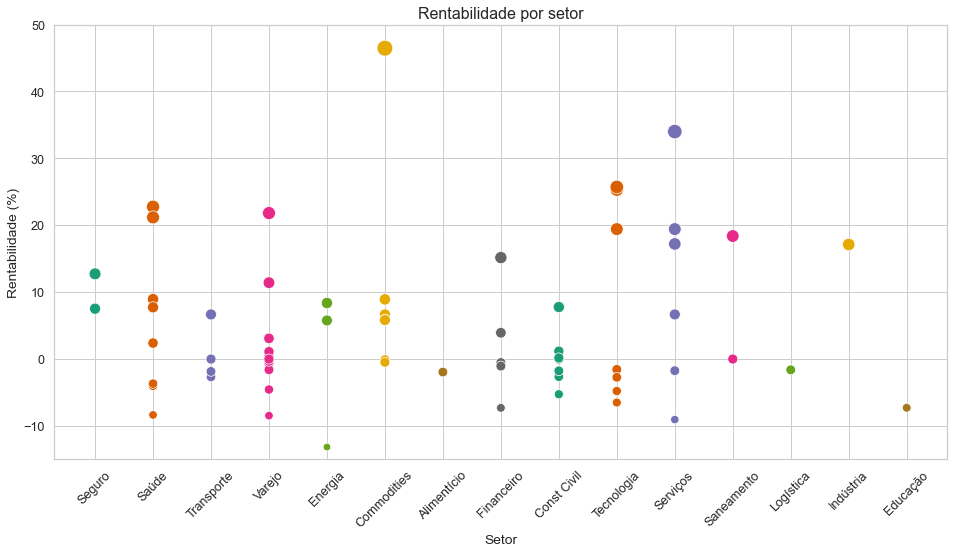

In [34]:
ipo_details['Media_faixa'] = (ipo_details['Min_faixa'] + ipo_details['Max_faixa']) / 2
ipo_details['%Faixa'] = (ipo_details['Preco_fixado'] / ipo_details['Media_faixa']) - 1

rent = rent_df.copy()
details = ipo_details.set_index('Tickers').copy()
correlacao = pd.concat([details, rent], axis =1)
today = rent_by_day.iloc[-1]
correlacao = pd.concat([correlacao, today], axis = 1)
correlacao.columns.values[14] = 'Today'
correlacao = correlacao.drop(columns=['Varejo', 'Institucional', 'Estrangeiros', 'Outros', 'Total_Investidores'])
correlacao

def plot_setor():
    sns.set(rc={'figure.figsize':(16,8)}, font_scale = 1.15, style='whitegrid')
    sns.scatterplot(data=correlacao[correlacao.index!='MOSI3'], x='Setor', y='1D', 
                    size = '1D', sizes = (10,250) , palette = 'Dark2', hue='Setor')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)
    plt.ylabel('Rentabilidade (%)')
    plt.title('Rentabilidade por setor', fontsize =16)
    plt.ylim([-15,50])

plot_setor()

#Foi retirado o MOSI3 (Tecnologia) do gráfico pois ele é um outlier de rentabilidade elevada,
#Logo, foi retirado.

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O gráfico acima mostra a rentabilidade por setor em flipagens, que seria 
o contexto em que as ações estão mais sucetíveis a ter os preços movimentados 
pela especulação e pouco conhecimento prévio da empresa. Observa-se um 
comportamento interessante no setor de commodities, o qual não registrou 
nenhum fechamento negativo no primeiro dia, talvez por conta da importância 
que as empresas desse setor têm na bolsa. É interessante também analisar 
como existem empresas vencedoras que cobrem as perdas geradas por outros 
papéis de mesmo, ou outro setor, o gráfico abaixo ajuda a identificar isso.
</div>

In [35]:
list_rent_1d = []
for t in tickers:
    list_rent_1d.append(rentability(t, 1))
dict_rent_1d = dict(zip(tickers,list_rent_1d))

df_rent = pd.DataFrame.from_dict(dict_rent_1d, orient='index').rename(columns={0:'Rentabilidade_1D'})
df_rent = df_rent.reset_index().rename(columns={'index':'Ticker'})
df_rent = df_rent.sort_values("Rentabilidade_1D", ascending = False).reset_index(drop=True)

menor_m15 = entremenos15_e_menos10 = entremenos10_e_men5 = entremen5_e_0 = 0
entre0_e_5 = entre5_e_10 = entre10_e_15 = maior_15 = 0
for i in range(df_rent.index.max() + 1):
    x = df_rent.loc[i, 'Rentabilidade_1D']
    if x < -15:
        menor_m15 += 1
    elif( -15 <= x < -10): 
        entremenos15_e_menos10 += 1
    elif( -10 <= x < -5): 
        entremenos10_e_men5 += 1
    elif(-5 <= x <0):
        entremen5_e_0 += 1 
    elif(0 <= x < 5):
        entre0_e_5 += 1 
    elif(5 <= x < 10):
        entre5_e_10 += 1         
    elif(10 <= x < 15):
        entre10_e_15 += 1 
    elif(15 < x):
        maior_15 += 1

df = pd.DataFrame({'<-15%': menor_m15, '-15% a -10%': entremenos15_e_menos10, '-10% a -5%': entremenos10_e_men5, 
                   '-5% a 0%': entremen5_e_0, '0% a 5%': entre0_e_5, '5% a 10%': entre5_e_10, 
                   '10% a 15%': entre10_e_15, '>15%': maior_15}, index = [0])
DF = df.T
DF = DF.reset_index().rename(columns={'index':'Valor', 0: 'Quantidade'})
DF

,Valor,Quantidade
0,<-15%,1
1,-15% a -10%,1
2,-10% a -5%,7
3,-5% a 0%,20
4,0% a 5%,11
5,5% a 10%,12
6,10% a 15%,2
7,>15%,15


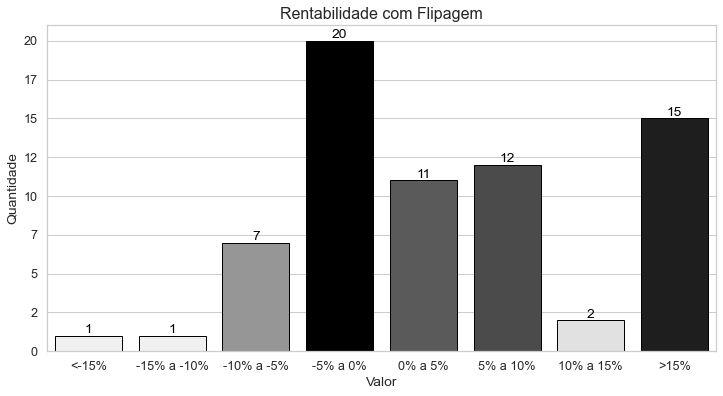

In [36]:
def plot_quantidade_por_rent(DF):
    sns.set(rc={'figure.figsize':(12,6)}, font_scale = 1.15, style='whitegrid')
    plot = sns.barplot(data=DF, x='Valor', y='Quantidade', palette = cm.gist_yarg(DF['Quantidade']*15),ec = 'black')
    for index, row in DF.iterrows():
        plot.text(row.name, row.Quantidade+0.175, round(row.Quantidade,2), color="black", ha="center")
    plot.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x))))
    plt.title('Rentabilidade com Flipagem', fontsize =16)

plot_quantidade_por_rent(DF)

## 4.3 Como se deu o comportamento das rentabilidades e volatilidades (incerteza de movimento) dos IPO's contra o IBOVESPA - índice que retrata a média da bolsa brasileira? 

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para descobrir se o investimento isolado em IPOs realmente vale a pena, 
ele teria que fornecer uma rentabilidade maior do que o índice Bovespa, visto 
que esse índice é um reflexo da rentabilidade média ponderada de ações que 
fundamentam a economia do país, e é tomado como base para se referir à 
rentabilidade geral da renda variável. Abaixo estão os gráficos referente a 
variação percentual da média das rentabilidades dos IPOs e do Ibovespa.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para medidas comparativas chamaremos a média das rentabilidades dos 
IPOs de “ETF”.
</div>

In [37]:
cota_ibov = cota_ibov.reset_index()
cota_ibov['Date'] = cota_ibov.apply(lambda x: pd.to_datetime(x.Date,format='%Y-%m-%d',errors='coerce'), axis=1)
cota_ibov = cota_ibov.set_index("Date")
ipo_ibov = pd.concat([ rent_by_day_mean, cota_ibov], axis = 1)

In [38]:
def mm(dias,data,i):
    data = data.iloc[i-dias:i]
    return data.variation.mean()

In [39]:
rent_mm = rent_by_day_mean.copy()
rent_mm = rent_mm.reset_index()
rent_mm['indice'] = list(rent_mm.index)
rent_mm['media_movel_200'] = rent_mm.apply(lambda x: mm(200,rent_mm,x.indice), axis = 1)
rent_mm['media_movel_100'] = rent_mm.apply(lambda x: mm(100,rent_mm,x.indice), axis = 1)
rent_lr = rent_mm.copy()
rent_lr = rent_lr.dropna().reset_index(drop=True)

Regressao Linear

In [40]:
result = linregress(rent_lr['indice'], rent_lr['media_movel_200'])
x = result.slope
y = result.intercept
print(f'{x}x + {y}')

0.07014528528372749x + -35.80425887757201


In [41]:
lista_x = list(rent_lr['indice'])
lista_y = []

for i in lista_x:
    lista_y.append(i*result.slope + result.intercept)

x = dict(zip(rent_lr.indice, lista_y))
linr= pd.DataFrame.from_dict(x, orient='index').rename(columns={0:'lin_regress'})
linr = linr.reset_index().rename(columns={'index': 'indice'})
rent_mm = pd.merge(rent_mm, linr, how='outer', on= 'indice')
rent_mm

,Date,variation,indice,media_movel_200,media_movel_100,lin_regress
0,2015-06-05,0.000000,0,NaN,NaN,NaN
1,2015-06-08,-0.863337,1,NaN,NaN,NaN
2,2015-06-09,-1.798566,2,NaN,NaN,NaN
3,2015-06-10,0.719420,3,NaN,NaN,NaN
4,2015-06-11,2.589922,4,NaN,NaN,NaN
...,...,...,...,...,...,...
1504,2021-06-30,79.312513,1504,54.120178,60.282840,69.694250
1505,2021-07-01,77.555960,1505,54.204148,60.303389,69.764395
1506,2021-07-02,80.689114,1506,54.318250,60.258530,69.834541
1507,2021-07-05,79.445808,1507,54.450362,60.244756,69.904686


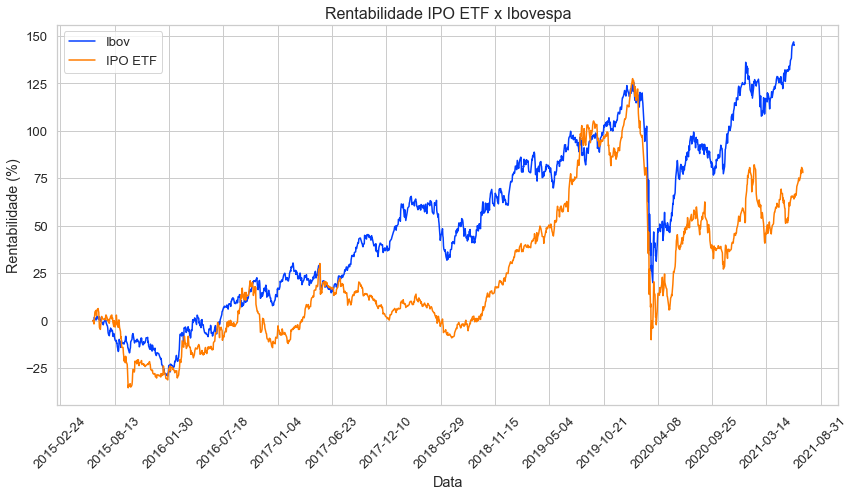

In [42]:
def plot_etf_ibov():
    sns.set(rc={'figure.figsize':(14,7)},palette='bright', style='whitegrid', font_scale=1.2)
    loc = plticker.MultipleLocator(base=170.0)
    axes = sns.lineplot( data=cota_ibov, x='Date', y='Cumulative')#, color='Blue')
    axes2 = sns.lineplot(data=rent_by_day_mean, x = 'Date', y='variation')#, color='Red')
    axes.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.legend(['Ibov','IPO ETF'],frameon=True)
    plt.xlabel('Data')
    plt.ylabel('Rentabilidade (%)')
    plt.title('Rentabilidade IPO ETF x Ibovespa', fontsize =16)
    #plt.ylim([-15,50])

plot_etf_ibov()

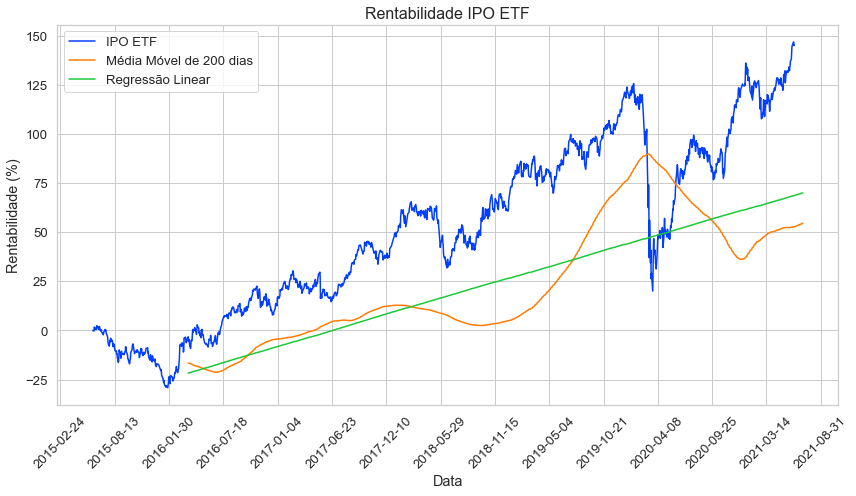

In [43]:
def plot_etf():
    sns.set(rc={'figure.figsize':(14,7)},palette = 'bright', style='whitegrid', font_scale=1.2)
    loc = plticker.MultipleLocator(base=170.0)
    axes = sns.lineplot( data=cota_ibov, x='Date', y='Cumulative')
    axes2 = sns.lineplot(data=rent_mm, x='Date', y='media_movel_200')
    axes3 = sns.lineplot(data=rent_mm, x='Date', y='lin_regress')
    axes.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.legend(['IPO ETF','Média Móvel de 200 dias','Regressão Linear'],frameon=True)
    plt.xlabel('Data')
    plt.ylabel('Rentabilidade (%)')
    plt.title('Rentabilidade IPO ETF', fontsize =16)

plot_etf()

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A curva de cor laranja é a média de 200 periodos do ETF (gráfico diário), e 
a reta de cor verde é uma regressão linear do valor dessa média para cada dia. 
Em outras palavras, essa reta cria um modelo que “prevê” o valor da média, claro 
que o valor está longe de ser preciso devido as oscilações do mercado, mas de modo geral, ela é um bom indicador de tendência e de valores para se tomar como base.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Em primeiro plano, é interessante visualizar a semelhança de 
movimentos, topos e fundos entre o Ibovespa e o ETF, fato que reforça o 
princípio definido por Charles Dow de que “os índices e as médias devem 
confirmar uns aos outros”. O que chama mais atenção é que a linha de preço do 
ETF se mantém abaixo do Ibov na maior parte do tempo, coroando, em relação 
ao ponto inicial de compra, o Índice Bovespa como opção mais rentável.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Entretanto, sabe-se que o mercado foi hostil aos IPOs por um longo 
período durante a década de 2010 devido as incertezas políticas e altas taxas 
de juros, tornando essa classe de ativo deficiente e incapaz de seguir o curso de 
alta junto ao resto da bolsa brasileira. Isso é visualizado com a ilustração da 
tendência baixista entre abril de 2017 e setembro de 2018. Apesar da notável 
diferença de rentabilidade ao longo prazo – com o Ibovespa sendo o mais 
consistente e de maiores resultados – houve uma ascendência repentina da 
rentabilidade dos IPOs a partir do final de 2018. Essa foi uma valorização de 
125% em pouco mais de um ano, e a linha de preço do ETF chegou a ficar um 
pouco acima da variação percentual que o Índice promovera – detalhe, o Índice 
demorou quase 4 anos para completar o mesmo movimento.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Em suma, o ETF se destaca em um fator: as movimentações de preço 
mostram oscilações maiores em menores períodos de tempo do que o IBOV. 
Esse fato pode gerar grande rentabilidade para investidores que fazem compra 
e venda em escalas de tempo menores, entretanto, em posições chave do 
gráfico, utilizando artifícios da análise técnica ou de fluxo e um correto 
gerenciamento de dinheiro. Além disso, apesar da grande quantia de empresas 
fazendo IPO em 2020 e 2021, muitas delas mostraram rentabilidade negativa –
o que pode ser analisado com o desvio padrão muito apontado para baixo no 
médio prazo - o que fez a rentabilidade média não se recuperar tão bem quanto 
o Índice por conta do rebaixamento provocado.
</div>

In [44]:
ibov = cota_ibov.reset_index().copy()
variation = ipo_df.copy()
variation['var'] = variation.apply(lambda x: (x.preult - x.preabe)/x.preabe, axis = 1)

ibov['vol_media_diaria'] = 0
ibov['vol_media_anual'] = 0
ibov['codneg'] = 'ibov'

variation['vol_media_diaria'] = 0
variation['vol_media_anual'] = 0

ibov['indice'] = list(ibov.index)

variation['indice'] = list(variation.index)

def vol_ant(data, ativo):
    data = data[data.codneg == ativo]
    abertura = dict_tickers[ativo]

    if data.index.max() == 0:
        vol = np.array([data['var'][0], (data['preabe'][0] - abertura)/abertura]).std()  
        return vol
    else:
        vol = data['var'].std()
        return vol
    
def vol_ant_ibov(data, ativo):
    data = data[data.codneg == ativo]
    vol = data['Var%'].std()
    return vol

In [45]:
ibov['vol_media_diaria'] = ibov.apply(lambda x: vol_ant_ibov(ibov[:x['indice']+1],'ibov' ), axis = 1)
ibov = ibov.drop(columns='indice')
ibov['vol_media_anual'] = ibov['vol_media_diaria']*(252**(1/2))
ibov

,Date,index,Último,Var%,Cumulative,vol_media_diaria,vol_media_anual,codneg
0,2015-06-05,0,52973.37,-1.03,0.000000,NaN,NaN,ibov
1,2015-06-08,1,52809.63,-0.31,-0.309099,0.509117,8.081980,ibov
2,2015-06-09,2,52815.99,0.01,-0.297093,0.532666,8.455815,ibov
3,2015-06-10,3,53876.44,2.01,1.704762,1.301486,20.660455,ibov
4,2015-06-11,4,53688.51,-0.35,1.349999,1.150861,18.269345,ibov
...,...,...,...,...,...,...,...,...
1481,2021-06-02,1481,129601.44,1.04,144.653946,1.708187,27.116630,ibov
1482,2021-06-04,1482,130125.78,0.40,145.643764,1.707632,27.107812,ibov
1483,2021-06-07,1483,130776.27,0.50,146.871721,1.707092,27.099238,ibov
1484,2021-06-08,1484,129787.11,-0.76,145.004443,1.706654,27.092289,ibov


In [46]:
variation['vol_media_diaria'] = variation.apply(lambda x: vol_ant(variation[:x['indice']+1],x.codneg ), axis = 1)
variation = variation.drop(columns='indice')
variation['vol_media_anual'] = variation['vol_media_diaria']*(252**(1/2))
variation

,date,codneg,preabe,preult,var,vol_media_diaria,vol_media_anual
0,2015-06-05,WIZS3,13.60,13.90,0.022059,0.040471,0.642457
1,2015-06-08,WIZS3,14.11,13.78,-0.023388,0.032136,0.510136
2,2015-06-09,WIZS3,13.78,13.65,-0.009434,0.023280,0.369566
3,2015-06-10,WIZS3,13.70,14.00,0.021898,0.022884,0.363279
4,2015-06-11,WIZS3,14.01,14.26,0.017844,0.020932,0.332281
...,...,...,...,...,...,...,...
22518,2021-06-09,TFCO4,13.45,13.45,0.000000,0.027733,0.440245
22519,2021-06-09,VAMO3,52.41,51.96,-0.008586,0.026448,0.419845
22520,2021-06-09,VIVA3,31.37,31.66,0.009245,0.039168,0.621774
22521,2021-06-09,WEST3,8.83,8.77,-0.006795,0.039820,0.632130


## Volatilidade do Ibovespa e do IPOs ETF

In [47]:
var_by_day = variation.pivot_table(values='vol_media_anual', index= 'date', columns='codneg')
var_by_day_mean = var_by_day.mean(axis = 1)
var_by_day_mean = pd.DataFrame(data=var_by_day_mean, columns=['media_volatilidade'])
var_by_day_mean = var_by_day_mean.reset_index(drop=False)

In [48]:
ibov['media_volatilidade_etf'] = var_by_day_mean.media_volatilidade*100

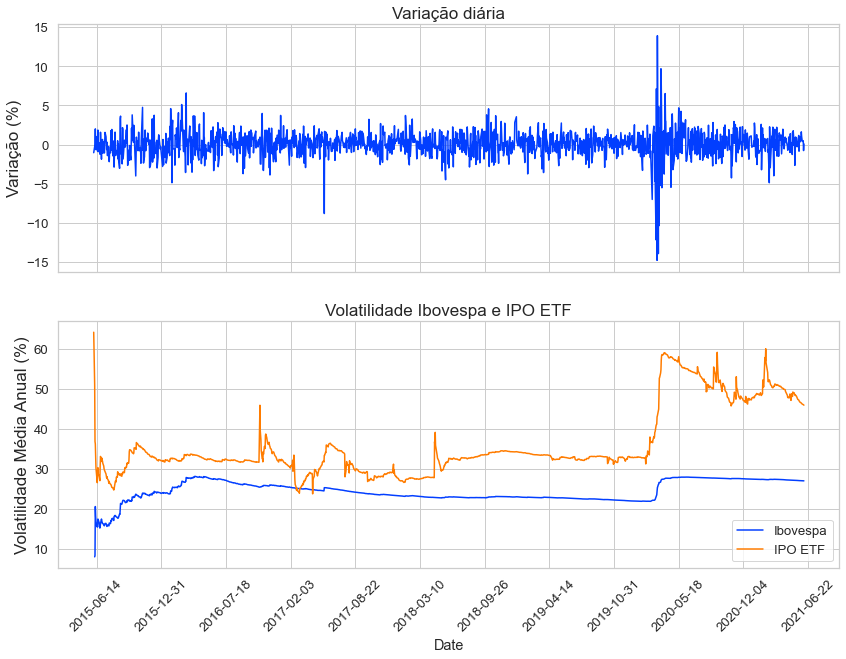

In [49]:
def plot_volatilidade():
    
    
    sns.set(rc={'figure.figsize':(14,10)},palette = 'bright', style='whitegrid', font_scale=1.2)
    
    fig, axes = plt.subplots(2, 1, sharex=True)

    loc = plticker.MultipleLocator(base=200)
    sns.lineplot(ax=axes[0], data=ibov, x='Date', y='Var%')
    sns.lineplot(ax=axes[1], data=ibov, x='Date', y='vol_media_anual')
    sns.lineplot(ax=axes[1], data=ibov, x='Date', y='media_volatilidade_etf')
    axes[0].xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.legend(['Ibovespa','IPO ETF'],frameon=True)
    # plt.xlabel('Data')
    # plt.ylabel('Rentabilidade (%)')

    axes[0].set_title('Variação diária', fontsize=17)
    axes[0].set_ylabel(f'Variação (%)', fontsize = 17)
    axes[1].set_title('Volatilidade Ibovespa e IPO ETF', fontsize=17)
    axes[1].set_ylabel(f'Volatilidade Média Anual (%)', fontsize = 17)

plot_volatilidade()

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Esse gráfico representa a volatilidade anual do IBOV e ETF com o passar 
do tempo. Por conta das tensões políticas e impeachment, a volatilidade do 
Índice Bovespa cresce de forma constante no ínicio do período analisado, depois 
do acontecido, há uma estabilização e decrescimento do valor. O gráfico da 
variação percentual diária possui picos e fundos que podem ser relacionados a 
momentos históricos como o Joesley Day, no dia 17 de maio de 2017, onde é 
possível enxergar uma variação negativa bem maior do que as variações 
adjacentes. Também é observado no final do período o aumento súbito da 
volatilidade e variação percentual provocada pelo início da pandemia. Note como 
o nível de volatilidade nesse período foi semelhante ao nível alcançado na época em que houve o impeachment da ex-presidente Dilma Rouseff, denotando a semelhança de sentimentos dos investidores em momentos como esse.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Em relação à volatilidade do ETF, ela alcança patamares bem mais altos 
do que o do IBOV e é notavelmente mais errática. Tal fato é esperado uma vez 
que a natureza dessa classe de ativos é a incerteza e movimentos especulativos, 
que por muitas vezes, são explosivos.
</div>

## 4.4 Existe correlação entre rentabilidade alta e outra variável que não seja bons fundamentos da empresa, ou seja, puramente especulação?

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Após tentar encontrar uma correlação entre rentabilidade de um ativo e 
indicadores técnicos – entre eles volume; percentual de investidores 
estrangeiros, institucionais e de pessoas físicas – não foi possível encontrar 
nenhuma correlação positiva, ou seja, esses fatores nada influenciam na 
movimentação positiva ou negativa do preço das empresas que fizeram IPO. 
Dessa forma, os preços são movimentados a partir da ideia que os investidores 
têm a respeito da empresa e da especulação oriunda do desejo de multiplicar o 
capital em cima de um papel recém-listado. Porém, ao longo do tempo, o preço 
da ação tende a ser reflexo dos fundamentos da empresa e do seu crescimento.
</div>

In [50]:
covid = covid_df.copy()

In [51]:
ibov_copy = ibov.copy()
ibov_copy = ibov_copy[ibov.Date >= '2021-01-01']
ibov_copy = ibov_copy.reset_index(drop=True)
ibov_copy = ibov_copy.rename(columns={'Date': 'data'})

In [52]:
vol_etf = var_by_day_mean.copy()
vol_etf = vol_etf[vol_etf.date >= '2020-01-01']
vol_etf = vol_etf.reset_index()
vol_etf = vol_etf.rename(columns={'date': 'data'})
vol_etf

,index,data,media_volatilidade
0,1130,2020-01-02,0.329767
1,1131,2020-01-03,0.329463
2,1132,2020-01-06,0.329377
3,1133,2020-01-07,0.329521
4,1134,2020-01-08,0.329931
...,...,...,...
351,1481,2021-06-02,0.464182
352,1482,2021-06-04,0.462800
353,1483,2021-06-07,0.461412
354,1484,2021-06-08,0.460935


In [53]:
covid_test = pd.merge(vol_etf, covid, how='inner', on= 'data')

In [54]:
covid_chart = pd.concat([ibov_copy.set_index('data'), covid[covid.data>='2020-01-01'].set_index('data')],axis=1).dropna()
covid_chart.corr()[['Var%', 'vol_media_anual', 'media_volatilidade_etf']]

,Var%,vol_media_anual,media_volatilidade_etf
index,0.120502,-0.909033,-0.432171
Último,0.236647,-0.697092,-0.502816
Var%,1.000000,-0.115120,-0.072195
Cumulative,0.236647,-0.697092,-0.502816
vol_media_diaria,-0.115120,1.000000,0.522250
vol_media_anual,-0.115120,1.000000,0.522250
media_volatilidade_etf,-0.072195,0.522250,1.000000
casosAcumulado,0.122069,-0.919788,-0.460971
casosNovos,0.145315,-0.084099,-0.053288
obitosAcumulado,0.121926,-0.949992,-0.514032


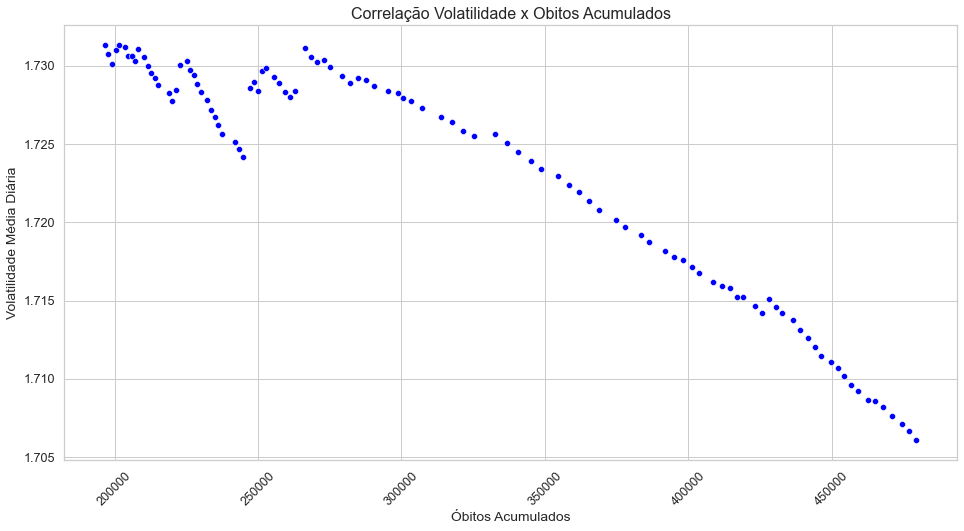

In [56]:
def plot_covid_corr():
    sns.set(rc={'figure.figsize':(16,8)}, font_scale = 1.15, style='whitegrid')
    sns.scatterplot(data=covid_chart, x='obitosAcumulado', y='vol_media_diaria', color='Blue')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)
    plt.xlabel('Óbitos Acumulados')
    plt.ylabel('Volatilidade Média Diária')
    plt.title('Correlação Volatilidade x Obitos Acumulados', fontsize =16)

plot_covid_corr()

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Foi procurado algum tipo de correlação entre o aumento da volatilidade e 
o número de óbitos por Covid-19 acumulados, com o propósito de verificar se há 
uma relação de causa/consequência prevalente. Não obtivemos resultados 
concordantes com essa hipótese, visto que a correlação entre eles se mostrou 
totalmente negativa, nos levando a assumir que o aumento da volatilidade foi causado 
pelo contexto socioeconômico do país, e não tem correlação nenhuma com o 
aumento dos óbitos acumulados, pois não há lógica em assumir que o aumento da quantidade de óbitos poderia 
estar causando a diminuição da volatilidade, sendo apenas uma coincidência. 
</div>

# 5 Conclusão

<div style="text-align: justify">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Um investimento ideal na bolsa de valores deve ser feito de maneira 
diversificada e com um bom gerenciamento de risco e dinheiro, não se 
restringindo apenas a investimentos nas empresas que estão abrindo capital. Ao 
possuir um papel para cada empresa listada, a estatística mostrou que a 
rentabilidade de investimentos em IPO é mais positiva de médio a longo prazo,
e o investimento se torna maleável uma vez que mais informações fundamentais 
e técnicas sobre a empresa/ação vão surgindo com o passar do tempo. Mesmo 
que existam várias empresas perdedoras, as vencedoras estão alí para cobrir o prejuízo.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;No início não se sabe qual empresa irá obter sucesso, e pode ser ao 
acaso a montagem de uma carteira apenas com empresas vencedoras ou 
perdedoras. Como não existe parâmetro claro, a estatística compra uma ação 
de cada empresa, e é tomado como base um investimento de zero interferência 
e descarte, ou seja, um ativo que está a desvalorizar até hoje não é descartado 
da carteira, e tal situação não se aproxima da realidade. Também é importante 
lembrar que a estatística não leva em consideração o sentimentos dos 
investidores perante ganhos ou perdas.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Independente dos fatos apresentados pela análise de dados, as decisões 
que devem ser tomadas são particulares ao investidor, não se recomenda tomar 
nenhuma atitude sem avaliação prévia minuciosa. A análise mostrada tem o 
único propósito de apontar as informações extraídas durante o estudo dos dados
recolhidos.
</div>

> Ganhos passados não são garantia de retornos futuros.